# TP 2 - Tópicos de Minería de Datos
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [ ]:
# import iniciales
library(randomForest)
library(kernlab)
library(MASS)
library(data.table)

##### Código proporcionado

In [2]:
# -------------------------------------------------------------------------------------
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------

forward.ranking <- function(x,y,method,verbosity=0,... ) {

	max.feat<-dim(x)[2] # Número total de variables
	num.feat<-1 # Número de variables elegidas en el momento
	list.feat<-1:max.feat

	# ranking inicial: elijo la variable con menor error de prediccion
  x.train<-matrix(0,dim(x)[1],1) # Variable de entrenamiento con solo las columnas elegidas
	class.error<-double(max.feat) # Error de cada variable
	# para cada i, creo el dataset con esa variable sola, entreno un modelo
	# y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat) {
		x.train[,1]<-x[,i]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	# guardo la variable con minimo error como primera. Guardo una lista
	# keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]
	# armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]]

	if(verbosity>1) cat("\nFirst chosen feature: ",colnames(x)[list.feat[1]],"\n")

  # loop principal. A cada paso agrego todas las variables disponibles,
	# de a una, le mido el error y me quedo con la de minimo error.
	# Hasta llegar a meter todas.
	while(num.feat < max.feat) {
    # class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat - num.feat)
		# para cada variable que me queda, la agrego al dataset del paso anterior,
		# entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]])
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		# me quedo con el modelo de minimo error, guardo ese feature en la lista
		# de las elegidas, lo saco de la lista de las que quedan, y actualizo
		# el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nChosen feature:",colnames(x)[keep.feat[best.index]])

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]]
	}


	search.names<-colnames(x)[list.feat]
	# le asigno a cada feature una importacia proporcional al orden en que
	# lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>0) {
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )
}

#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0) {
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y) {
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}

#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar
crea.ruido.unif<-function(n=100,d=2){
	x<-runif(2*n*d,min=-1)	#genero los datos
	dim(x)<-c(2*n,d)
	return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

--------------------------------------------------------------------------------
## Ejercicio 1

In [3]:
backward.ranking <- function(x,y,method,verbosity=0,... ) {
	max.feat<-dim(x)[2] # Número total de variables
	num.feat <- max.feat
	discarded.feat<-1:max.feat
	keep.feat <- discarded.feat

  x.train<-matrix(0,dim(x)[1],1) # Variable de entrenamiento con solo las columnas elegidas
	x.prev <- x

  # loop principal. A cada paso quito todas las variables disponibles,
	# de a una, le mido el error y descarto con la de mínimo error.
	# hasta no quedarme con ninguna.
	while(num.feat > 1) {
    # class.error guarda el error de cada modelo. Son num.feat modelos.
		class.error<-double(num.feat)
		# para cada variable que me queda, la saco del dataset del paso anterior,
		# entreno el modelo y le mido el error.
		for(i in 1:num.feat){
			x.train<-x.prev[,-i, drop=FALSE]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		# me quedo con el modelo de minimo error, guardo ese feature en la lista
		# de las descartadas, lo saco de la lista de las que quedan, y actualizo
		# el dataset de partida de la iteracion.
		worst.index<-which.min(class.error)
		discarded.feat[(max.feat - num.feat) + 1]<-keep.feat[worst.index]
		if(verbosity>1) cat("\n---------\nStep ",(max.feat - num.feat) + 1,"\nDiscarded feature: ",colnames(x)[keep.feat[worst.index]])

		keep.feat<-keep.feat[-worst.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat-1
		x.prev<-x[,keep.feat[1:num.feat], drop=FALSE] #TODO esta línea
	}

	# la única variable que quedó sin descartar es la más importante
	discarded.feat[max.feat]<-keep.feat[1]
	if (verbosity > 1) cat("\nLast discarded feature: ",colnames(x)[keep.feat[1]])

	# las variables menos importantes se descartaron primero -> las mas importantes
	# están al final, doy vuelta la lista
	list.feat <- rev(discarded.feat)
	search.names<-colnames(x)[list.feat]
	# le asigno a cada feature una importacia proporcional al orden en que
	# lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>0) {
		cat("\n---------\nFinal ranking ",max.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )
}

In [4]:
kruskalwallis.ranking <- function(x, y, verbosity=0,...) {
  num.feat <- dim(x)[2]
  class.statistic <- double(num.feat)

  for (i in 1:num.feat){
    x.test <- x[,i]
    class.statistic[i] <- kruskal.test(x.test,y)$statistic
    if (verbosity > 1) {
      cat("\n---------\nFeature ",i,colnames(x)[i],"\nKruskal-Wallis chi-squared:",class.statistic[i])
    }
  }

  list.feat <- sort(class.statistic,decreasing=TRUE,index=T)$ix
  search.names <- colnames(x)[list.feat]

  # le asigno a cada feature una importacia proporcional al orden en que
	# lo seleccionamos
	imp <- (num.feat:1)/num.feat
	names(imp) <- search.names

  if (verbosity > 0) {
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

  return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )
}

In [5]:
rfe.ranking <- function(x,y,method,verbosity=0,... ) {
	num.feat <- dim(x)[2]
	discarded.feat <- 1:num.feat
	keep.feat <- discarded.feat

	for (i in 1:num.feat) {
		x.train <- as.matrix(x[,keep.feat])
		rankings <- do.call(method, c(list(x.train, y), list(...)) )
		worst.index <- rankings$feats[1]
		if(verbosity>1) cat("\n---------\nStep ",i,"\nDiscarded feature: ",colnames(x)[keep.feat[worst.index]],"\n")
		discarded.feat[i] <- keep.feat[worst.index]
		keep.feat <- keep.feat[-worst.index]
	}


	# las variables menos importantes se descartaron primero -> las mas importantes
	# están al final, doy vuelta la lista
	list.feat <- rev(discarded.feat)
	search.names<-colnames(x)[list.feat]
	# le asigno a cada feature una importacia proporcional al orden en que
	# lo seleccionamos
	imp<-(num.feat:1)/num.feat
	names(imp)<-search.names

	if(verbosity>0) {
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )
}

--------------------------------------------------------------------------------
## Ejercicio 2

Primero genero y grafico los datos

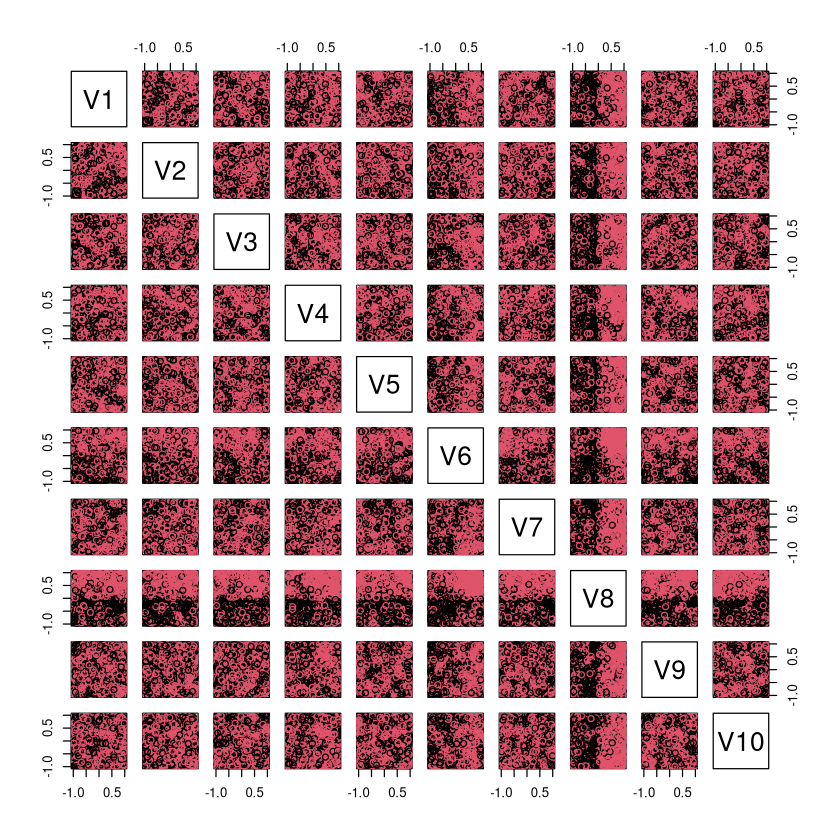

In [13]:
#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

x.datosA <- datosA[,-11]
y.datosA <- datosA[,11]

plot(x.datosA, col=y.datosA)

Como era esperable, la variable 8 es la que más permite diferenciar las clases
de los puntos, después en menor medida la 6 pero no es notable en el plot generado.
El orden a esperar en los resultados sería V8, V6, V4, V2 y luego al azar.

In [17]:
cat("\n-- Datos A --\n")
cat("\n-- Forward ranking random forest --\n")
FORW.rf <- forward.ranking(x.datosA,y.datosA,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=1)
cat("\n-- Forward ranking lda --\n")
FORW.lda <- forward.ranking(x.datosA,y.datosA,method="lda.est", verbosity=1)

cat("\n-- Backward ranking random forest --\n")
BACK.rf <- backward.ranking(x.datosA,y.datosA,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=1)
cat("\n-- Backward ranking lda --\n")
BACK.lda <- backward.ranking(x.datosA,y.datosA,method="lda.est", verbosity=1)

cat("\n-- Kruskal-Wallis --\n")
KW <- kruskalwallis.ranking(x.datosA, y.datosA, verbosity = 1)

cat("\n-- RFE linear random forest --\n")
RFE.rf <- rfe.ranking(x.datosA,y.datosA,method="imp.rf", tot.trees=100, verbosity=1)
cat("\n-- RFE linear SVM --\n")
RFE.linsvm <- rfe.ranking(x.datosA,y.datosA,method="imp.linsvm", verbosity=1)


-- Datos A --

-- Forward ranking random forest --

---------
Final ranking  10  features.
Features:  V8 V6 V7 V10 V1 V2 V5 V3 V9 V4 

-- Forward ranking lda --

---------
Final ranking  10  features.
Features:  V8 V9 V3 V5 V1 V10 V7 V4 V2 V6 

-- Backward ranking random forest --

---------
Final ranking  10  features.
Features:  V8 V6 V1 V5 V4 V10 V3 V7 V2 V9 

-- Backward ranking lda --

---------
Final ranking  10  features.
Features:  V8 V9 V10 V7 V5 V3 V4 V1 V2 V6 

-- Kruskal-Wallis --

---------
Final ranking  10  features.
Features:  V8 V6 V4 V2 V7 V1 V10 V3 V9 V5 

-- RFE linear random forest --

---------
Final ranking  10  features.
Features:  V8 V6 V4 V1 V3 V10 V2 V7 V5 V9 

-- RFE linear SVM --

---------
Final ranking  10  features.
Features:  V8 V6 V4 V2 V7 V10 V5 V9 V1 V3 


En general, todos los métodos lograron reconocer correctamente a la octava variable
como la de mayor importancia. Luego en las siguientes variables los resultados
no fueron tan buenos, en forward y backward ranking las restantes variables elegidas
no tienen relación alguna a como los datos fueron generados, pero para RFE y el
test no paramétrico de Kruskal-Wallis se reconocieron correctamente las siguientes
3 variables (V6, V4 y V2), quizás con alguna pequeña variación entre diferentes ejecuciones,
estos últimos métodos resultaron ser los más consistentes y con mejores resultados
para estos datos.

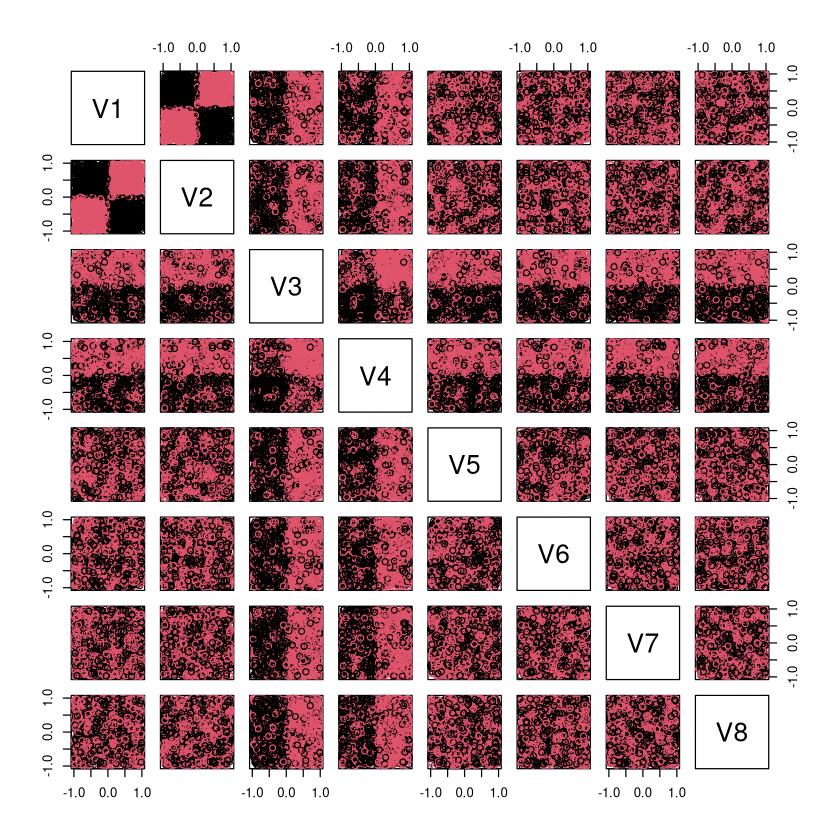

In [6]:
#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

x.datosB <- datosB[,-9]
y.datosB <- datosB[,9]
plot(x.datosB, col=y.datosB)

En el gráfico se observa claramente como las clases se diferencian por un xor
entre los signos de V1 y V2. Y en menor medida por V3 y V4, aunque acá la distinción entre clases
siguen más una línea recta. En los resultados debería esperar
obtener a V1 y V2 como las dos variables de mayor importancia, seguidas por V3 y V4
y luego al azar.

In [7]:
cat("\n-- Datos B --\n")
cat("\n-- Forward ranking random forest --\n")
FORW.rf <- forward.ranking(x.datosB,y.datosB,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=1)
cat("\n-- Forward ranking lda --\n")
FORW.lda <- forward.ranking(x.datosB,y.datosB,method="lda.est", verbosity=1)

cat("\n-- Backward ranking random forest --\n")
BACK.rf <- backward.ranking(x.datosB,y.datosB,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=1)
cat("\n-- Backward ranking lda --\n")
BACK.lda <- backward.ranking(x.datosB,y.datosB,method="lda.est", verbosity=1)

cat("\n-- Kruskal-Wallis --\n")
KW <- kruskalwallis.ranking(x.datosB, y.datosB, verbosity = 1)

cat("\n-- RFE random forest --\n")
RFE.rf <- rfe.ranking(x.datosB,y.datosB,method="imp.rf", tot.trees=100, verbosity=1)
cat("\n-- RFE linear SVM --\n")
RFE.linsvm <- rfe.ranking(x.datosB,y.datosB,method="imp.linsvm", verbosity=1)


-- Datos B --

-- Forward ranking random forest --

---------
Final ranking  8  features.
Features:  V3 V4 V6 V8 V7 V2 V1 V5 

-- Forward ranking lda --

---------
Final ranking  8  features.
Features:  V4 V8 V3 V7 V6 V5 V1 V2 

-- Backward ranking random forest --

---------
Final ranking  8  features.
Features:  V2 V1 V7 V8 V6 V5 V4 V3 

-- Backward ranking lda --

---------
Final ranking  8  features.
Features:  V4 V8 V3 V7 V6 V5 V2 V1 

-- Kruskal-Wallis --

---------
Final ranking  8  features.
Features:  V3 V4 V6 V7 V5 V8 V2 V1 

-- RFE random forest --

---------
Final ranking  8  features.
Features:  V1 V2 V4 V3 V7 V6 V8 V5 

-- RFE linear SVM --

---------
Final ranking  8  features.
Features:  V4 V3 V6 V2 V1 V8 V5 V7 


Para estos datos los resultados son variados. La mayoría de los métodos
terminan eligiendo primero a las variables V3 y V4, donde utilizando estas dos
la distinción entre clases no está tan marcada, pero al verlas en un gráfico como el
de arriba esta distinción está más marcada por una recta lineal. Y en menor
medida, solo dos métodos (ambos utilizando random forest para calcular la importancia
de las variables) reconocieron el XOR presente entre los signos de las variables V1 y V2.

--------------------------------------------------------------------------------
## Ejercicio 3

In [7]:
generatePoints <- function(d, n, std, center0, center1) {
  lenClass1 <- floor(n / 2)
  lenClass0 <- n - lenClass1

  class0 <- replicate(n = lenClass0, as.list(c(rnorm(d, mean = center0, sd = std), 0)), simplify = FALSE)
  class1 <- replicate(n = lenClass1, as.list(c(rnorm(d, mean = center1, sd = std), 1)), simplify = FALSE)
  data <- c(class0, class1)

  df <- rbindlist(data)
  colnames(df) <- c(1:d, "Class")
  df <- as.data.frame(df)
  df$Class <- as.factor(df$Class)
  df
}

generateDiagonal <- function(d, n, C) {
  generatePoints(d, n, C * sqrt(d), rep(-1, d), rep(1, d))
}

In [13]:
# funcion para buscar cuantos elementos de a hay en b
buscar <- function(a, b) {
  l1 <- as.list(a)
  l2 <- as.list(b)

  results <- l1 %in% l2
  results <- results[results == TRUE]
  return(length(results))
}

# genero los datos y el ruido a agregarle
datosSinRuido <- generateDiagonal(10, 100, 2)
ruido <- crea.ruido.unif(n=50,d=90)[,-91]
x.datos <- datosSinRuido[,-11]
y.datos <- datosSinRuido[,11]
x.datos <- cbind(x.datos, ruido)

repeticiones <- 30

# Voy a probar 4 métodos donde 3 de esos tienen 2 variantes, 7 en total
coincidencias <- matrix(0, 7, 1)

var.originales <- colnames(datosSinRuido)[-11]

# lda tira warning porque las variables son colineares, suprimo temporalmente con esto
defaultW <- getOption("warn") 
options(warn = -1) 

for (i in 1:repeticiones) {
  FORW.rf <- forward.ranking(x.datos,y.datos,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=0)
  coincidencias[1] <- coincidencias[1] +  buscar(var.originales, FORW.rf$ordered.names.list[1:10])
  FORW.lda <- forward.ranking(x.datos,y.datos,method="lda.est", verbosity=0)
  coincidencias[2] <- coincidencias[2] +  buscar(var.originales, FORW.lda$ordered.names.list[1:10])

  BACK.rf <- backward.ranking(x.datos,y.datos,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=0)
  coincidencias[3] <- coincidencias[3] +  buscar(var.originales, BACK.rf$ordered.names.list[1:10])
  BACK.lda <- backward.ranking(x.datos,y.datos,method="lda.est", verbosity=0)
  coincidencias[4] <- coincidencias[4] +  buscar(var.originales, BACK.lda$ordered.names.list[1:10])

  KW <- kruskalwallis.ranking(x.datos, y.datos, verbosity = 0)
  coincidencias[5] <- coincidencias[5] +  buscar(var.originales, KW$ordered.names.list[1:10])

  RFE.rf <- rfe.ranking(x.datos,y.datos,method="imp.rf", tot.trees=100, verbosity=0)
  coincidencias[6] <- coincidencias[6] +  buscar(var.originales, RFE.rf$ordered.names.list[1:10])
  RFE.linsvm <- rfe.ranking(x.datos,y.datos,method="imp.linsvm", verbosity=0)
  coincidencias[7] <- coincidencias[7] +  buscar(var.originales, RFE.linsvm$ordered.names.list[1:10])
}

options(warn = defaultW)

coincidencias <- (coincidencias / 10) / repeticiones
coincidencias

0.07666667
0.10000000
0.06333333
0.20666667
0.40000000
0.14666667
0.30000000


En este punto no sabría qué concluir exactamente, los resultados no son muy buenos,
solo como máximo un 40% de variables acertadas para el test de Kruskal-Wallis y el
resto por debajo, esto no me sería muy útil si luego quisiera construir
un modelo de clasificación con estos datos, aunque esto lo puedo decir solo
porque ya sé cuales variables son ruidos y cuales tienen información relevante.